# BMI/CS 576 Fall 2023 - HW5
The objectives of this homework are to practice with

* HMMs
* K-means clustering

## HW policies
Before starting this homework, please read over the [homework policies](https://canvas.wisc.edu/courses/374201/pages/hw-policies) for this course.  In particular, note that homeworks are to be completed *individually* and plagiarism from any source (with the one exception noted below) will be considered **academic misconduct**.

You are welcome to use any code from the weekly notebooks (including the official solutions) in your solutions to the HW.

## Modules for this HW

In [1]:
import hmm
import fasta
from matplotlib import pyplot as plt

## PROBLEM 1: Motif HMM (25 points)

A common task in bioinformatics is to identify the locations of a specified pattern, or "motif," within a biological sequence.  For example, transcription factors are proteins that bind to DNA and each factor typically prefers to bind to a specific short pattern of bases in the DNA.  However, these patterns are often degenerate, which makes finding them a non-trivial task.  For example, a transcription factor might strongly bind to the  pattern "GATTACA", but may also bind to variations on this pattern, such as "CATTACA", "GATCATA", or "AATTAGA."  In this problem, we will model a sequence containing zero or more (hidden) instances of a motif using a Hidden Markov model, with a generic state transition diagram shown below.

![hmm diagram](hmm_diagram.png)

In this model, each motif instance has a fixed width, $w$, and is separated by other instances by one or more characters from a background distribution (represented by state "B"). Each position of the motif is represented by a state (e.g., "M2") which tends to emit a particular "consensus" character, but with some smaller probability emits one of the other characters of the specified alphabet.  We will refer to the concatenation of the consensus characters at each position of the pattern as the "consensus sequence."  For example, "GATTACA" is the consensus sequence in the example given above.

Implement a function `motif_hmm`, which instantiates an HMM of this form, given a consensus sequence (`consensus_seq`), the transition probability (`b`) from the background state to the first state of the motif, the probability of each motif state emitting its consensus character (`p_consensus`), and the alphabet (`alphabet`) for the sequences it represents (e.g., the characters of DNA).  Below are the implementation details that you will need to follow:

* Your function should return an instance of the class `hmm.HiddenMarkovModel`
* The motif states should be named "M1", "M2", etc., for each position in the motif, and the background state should be named "B".
* The states should be ordered with the motif states first and the background state last
* For each motif state, the probability of emitting its consensus character should be set to `p_consensus` and the remaining probability should be uniformly distributed across all other characters.

### An updated HMM class

The HMM class that we have implemented in the activities, along with a number of helper functions, are found in the `hmm` module included with this notebook.  There are a few minor changes in how the HMM class works, which will be helpful for this HW.  The changes are:

1. States may now be represented by arbitrary strings, rather than individual characters.  As a result, a state path (such as what is returned by the `most_probable_path` method) is now represented by a *list of strings*.  This will make it easier to design an HMM with a large number of states.
2. The Viterbi, Forward, and Backward algorithms now take advantage of the sparsity (of non-zero transitions) of the HMM.  This results in efficiency gains, particular for HMMs with large numbers of states but relatively few transitions, like the model we are using in this HW.
3. The `estimate_parameters` method can now use two different pseudocounts, one for emission probabilities and the other for transition (including initial) probabilities.

In [2]:
def motif_hmm(consensus_seq, b, p_consensus, alphabet):
    """Constructs an HMM model for sequences contaning occurrences of a motif separated by 
       characters generated by a background model.

    Args:
        consensus_seq: the consensus sequence for the motif
        b: the transition probability from the background state to the first motif state
        p_consensus: the probability that the character emitted by a motif state is equal to 
                     its consensus character
        alphabet: A string giving the possible characters emitted by the HMM
    Returns:
        An HMM object
    """
    ### BEGIN SOLUTION
    states = [f"M{i}" for i in range(1, len(consensus_seq) + 1)] + ["B"]
    chars = alphabet
    
    transitions = hmm.matrix(len(states), len(states), initial_value = 0)
    for i in range(len(consensus_seq)):
        transitions[i][i + 1] = 1.0
    transitions[-1][-1] = 1 - b
    transitions[-1][0] = b
    
    initial_probs = [0] * len(states)
    initial_probs[-1] = 1

    emissions = hmm.matrix(len(states), len(alphabet), (1 - p_consensus) / (len(alphabet) - 1))
    for i, c in enumerate(consensus_seq):
        emissions[i][alphabet.index(c)] = p_consensus
    emissions[-1] = [1 / len(alphabet) for _ in range(len(alphabet))]
    
    return hmm.HiddenMarkovModel(states, chars, transitions, initial_probs, emissions)
    ### END SOLUTION 

## Tests for `motif_hmm`

In [3]:
# alpabets
DNA = "ACGT"
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"

# three toy motif HMMs
mini_model          = motif_hmm("G",            0.1,  0.8, DNA)
cat_model           = motif_hmm("CAT",          0.01, 0.9, DNA)
tiger_model         = motif_hmm("TIGER",        0.05, 0.7, AMINO_ACIDS)
malayan_tiger_model = motif_hmm("MALAYANTIGER", 0.02, 0.6, AMINO_ACIDS)

In [4]:
# test p1_chars (4 points)
assert mini_model.chars == DNA
assert cat_model.chars == DNA
assert tiger_model.chars == AMINO_ACIDS
assert malayan_tiger_model.chars == AMINO_ACIDS
print("SUCCESS: p1_chars")

SUCCESS: p1_chars


In [5]:
# test p1_states (4 points)
assert mini_model.states == ['M1', 'B']
assert cat_model.states == ['M1', 'M2', 'M3', 'B']
assert tiger_model.states == ['M1', 'M2', 'M3', 'M4', 'M5', 'B']
assert malayan_tiger_model.states == ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'B']
print("SUCCESS: p1_states")

SUCCESS: p1_states


In [6]:
# test p1_initial_probs (4 points)
assert mini_model.initial_probs == [0, 1]
assert cat_model.initial_probs == [0, 0, 0, 1]
assert tiger_model.initial_probs == [0, 0, 0, 0, 0, 1]
assert malayan_tiger_model.initial_probs == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
print("SUCCESS: p1_initial_probs")

SUCCESS: p1_initial_probs


In [7]:
# test p1_transition_prob_matrix (4 points)
assert mini_model.transition_prob_matrix == [
    [0, 1.0], 
    [0.1, 0.9]]
assert cat_model.transition_prob_matrix == [
    [0, 1.0, 0, 0], 
    [0, 0, 1.0, 0], 
    [0, 0, 0, 1.0], 
    [0.01, 0, 0, 0.99]]
assert tiger_model.transition_prob_matrix == [
    [0, 1.0, 0, 0, 0, 0], 
    [0, 0, 1.0, 0, 0, 0], 
    [0, 0, 0, 1.0, 0, 0], 
    [0, 0, 0, 0, 1.0, 0], 
    [0, 0, 0, 0, 0, 1.0], 
    [0.05, 0, 0, 0, 0, 0.95]]
assert malayan_tiger_model.transition_prob_matrix == [
    [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0], 
    [0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.98]]
print("SUCCESS: p1_transition_prob_matrix")

SUCCESS: p1_transition_prob_matrix


In [8]:
# test p1_emission_prob_matrix (4 points)
assert hmm.round_matrix(mini_model.emission_prob_matrix, 3) == [
    [0.067, 0.067, 0.8, 0.067], 
    [0.25, 0.25, 0.25, 0.25]]
assert hmm.round_matrix(cat_model.emission_prob_matrix, 3) == [
    [0.033, 0.9, 0.033, 0.033], 
    [0.9, 0.033, 0.033, 0.033], 
    [0.033, 0.033, 0.033, 0.9], 
    [0.25, 0.25, 0.25, 0.25]]
assert hmm.round_matrix(tiger_model.emission_prob_matrix, 3) == [
    [0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.7, 0.016, 0.016, 0.016], 
    [0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.7, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016], 
    [0.016, 0.016, 0.016, 0.016, 0.016, 0.7, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016], 
    [0.016, 0.016, 0.016, 0.7, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016],
    [0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.7, 0.016, 0.016, 0.016, 0.016, 0.016], 
    [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]
assert hmm.round_matrix(malayan_tiger_model.emission_prob_matrix, 3) == [
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.6],
    [0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.6, 0.021, 0.021, 0.021, 0.021, 0.021],
    [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]
print("SUCCESS: p1_emission_prob_matrix")

SUCCESS: p1_emission_prob_matrix


In [9]:
# test p1_hidden (5 points)
### BEGIN HIDDEN TESTS
hidden_hmm = motif_hmm("1100110011", 0.001, 0.95, "01")
assert hidden_hmm.chars == "01"
assert hidden_hmm.states == ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'B']
assert hidden_hmm.initial_probs == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
assert hmm.round_matrix(hidden_hmm.emission_prob_matrix, 3) == [
    [0.05, 0.95],
    [0.05, 0.95],
    [0.95, 0.05],
    [0.95, 0.05],
    [0.05, 0.95],
    [0.05, 0.95],
    [0.95, 0.05],
    [0.95, 0.05],
    [0.05, 0.95],
    [0.05, 0.95],
    [0.5, 0.5]]
assert hmm.round_matrix(hidden_hmm.transition_prob_matrix, 3) == [
    [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0],
    [0.001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.999]]
print("SUCCESS: p1_hidden")
### END HIDDEN TESTS

SUCCESS: p1_hidden


## PROBLEM 2: Finding TRS in the SARS-CoV-2 genome (25 points)

Within an infected cell, SARS-CoV-2 generates a number of "subgenomic" RNAs (sgRNAs) from its genome, each of which is a copy of the genome with a single large deletion.  Each sgRNA corresponds to one of the genes in the genome, and the translation of a sgRNA results in the protein for its corresponding gene.  The structures of the sgRNAs are shown in the figure below, which was generated from the [UCSC Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=wuhCor1).  In this figure, "gRNA" is the full-length genome and the structures below it are the sgRNAs (the lines with arrows are the deletions in the sgRNAs).  The generation of the sgRNAs is mediated instances of a "transcription regulatory sequence" (TRS), the locations for which are shown in the top track (TRS sites).  Each sgRNA is the result of a pairing of the 5' (left-most) TRS with one of the TRS at the 3' end.

![sgRNAs in SARS-CoV-2](sarscov2_sgrna.png)


**(a)** The consensus sequence for the TRS is `CTAAACGAACTT`.  How many times does this sequence occur *exactly* within the SARS-CoV-2 genome?  The genome for SARS-CoV-2 can be found in the file `"sarscov2_genome.fasta`.  Show your code.

In [10]:
### BEGIN SOLUTION
trs_consensus = "CTAAACGAACTT"
sarscov2_genome = fasta.read_sequences_from_fasta_file("sarscov2_genome.fasta")[0][1]

pos = -1
exact_trs_positions = []
while True:
    pos = sarscov2_genome.find(trs_consensus, pos + 1)
    if pos == -1: break
    exact_trs_positions.append(pos)
print("The TRS sequence occurs exactly %d time(s) in the genome" % len(exact_trs_positions))
print("These occurrences are located at the following positions:", exact_trs_positions)
### END SOLUTION

The TRS sequence occurs exactly 1 time(s) in the genome
These occurrences are located at the following positions: [65]


**(b)** Using your `motif_hmm` function from problem 1, create an HMM for the TRS.  Use $b = 0.01$ and $p\_consensus = 0.8$.  Run the Viterbi algorithm with this HMM and the SARS-CoV-2 genome to find the most probable path.  List the start positions of the motif occurrences in the most probable path.

In [11]:
### BEGIN SOLUTION
trs_hmm = motif_hmm(trs_consensus, 0.01, 0.8, DNA)
path_vit = trs_hmm.most_probable_path(sarscov2_genome)
def all_indices(value, lst):
    return [i for i, elt in enumerate(lst) if elt == value]
viterbi_start_positions = all_indices("M1", path_vit)
viterbi_start_positions
### END SOLUTION

[65,
 2470,
 4576,
 5786,
 6700,
 8654,
 10132,
 12043,
 12737,
 13280,
 14608,
 15773,
 15856,
 16762,
 21551,
 24774,
 25099,
 25159,
 25380,
 26468,
 27383,
 27483,
 27883,
 28255]

**(c)** The file `trs.bed` contains the true coordinates of TRS instances in the SARS-CoV-2 genome.  This file is in [BED](https://en.wikipedia.org/wiki/BED_(file_format)) format.  Parse this file to obtain a list of the true start positions of TRS instances.  
* **(i)** How many true start positions did the Viterbi path recover?
* **(ii)** How many true start positions did the Viterbi path miss?
* **(iii)** How many false start positions did the Viterbi path predict?

In [12]:
### BEGIN SOLUTION
true_trs_positions = []
for line in open("trs.bed"):
    chrom, start, end = line.split("\t")
    true_trs_positions.append(int(start))
print("True TRS positions:", true_trs_positions)

def viterbi_accuracy(predicted, truth):
    true_positives = sorted(predicted & truth)
    false_negatives = sorted(truth - predicted)
    false_positives = sorted(predicted - truth)
    print("Viterbi predicted", len(true_positives), "correct positions:", true_positives)
    print("Viterbi missed", len(false_negatives), "true positions:", false_negatives)
    print("Viterbi predicted", len(false_positives), "incorrect positions:", false_positives)

viterbi_accuracy(set(viterbi_start_positions), set(true_trs_positions))
### END SOLUTION

True TRS positions: [65, 21551, 25380, 26232, 26468, 27036, 27383, 27669, 27883, 28255]
Viterbi predicted 7 correct positions: [65, 21551, 25380, 26468, 27383, 27883, 28255]
Viterbi missed 3 true positions: [26232, 27036, 27669]
Viterbi predicted 17 incorrect positions: [2470, 4576, 5786, 6700, 8654, 10132, 12043, 12737, 13280, 14608, 15773, 15856, 16762, 24774, 25099, 25159, 27483]


**(d)** Train your HMM using the SARS-CoV-2 genome and a state path constructed using the true TRS start positions.  Use an `emission_pseudocount` of **1** and a `transition_pseudocount` of **0** for this task.  Run the Viterbi algorithm again.  Repeat part (c) to evaluate how well the Viterbi path recovers the true TRS start positions.

In [13]:
### BEGIN SOLUTION
training_states = ["B"] * len(sarscov2_genome)
for start in true_trs_positions:
    for i in range(len(trs_consensus)):
        training_states[start + i] = "M%d" % (i + 1)

trs_hmm.estimate_parameters([(training_states, sarscov2_genome)], emission_pseudocount = 1)

path_vit2 = trs_hmm.most_probable_path(sarscov2_genome)
viterbi_start_positions2 = all_indices("M1", path_vit2)
viterbi_accuracy(set(viterbi_start_positions2), set(true_trs_positions))
### END SOLUTION

Viterbi predicted 7 correct positions: [65, 21551, 25380, 26468, 27383, 27883, 28255]
Viterbi missed 3 true positions: [26232, 27036, 27669]
Viterbi predicted 0 incorrect positions: []


**(e)** With your trained HMM from part (d), compute the posterior matrix.  Create a scatter plot with the x-axis representing the position along the genome and the y-axis giving the posterior probability that a TRS starts at that position.  Color the points that correspond to the true TRS start positions (consider using the `c` argument to `pyplot.scatter` for this purpose).

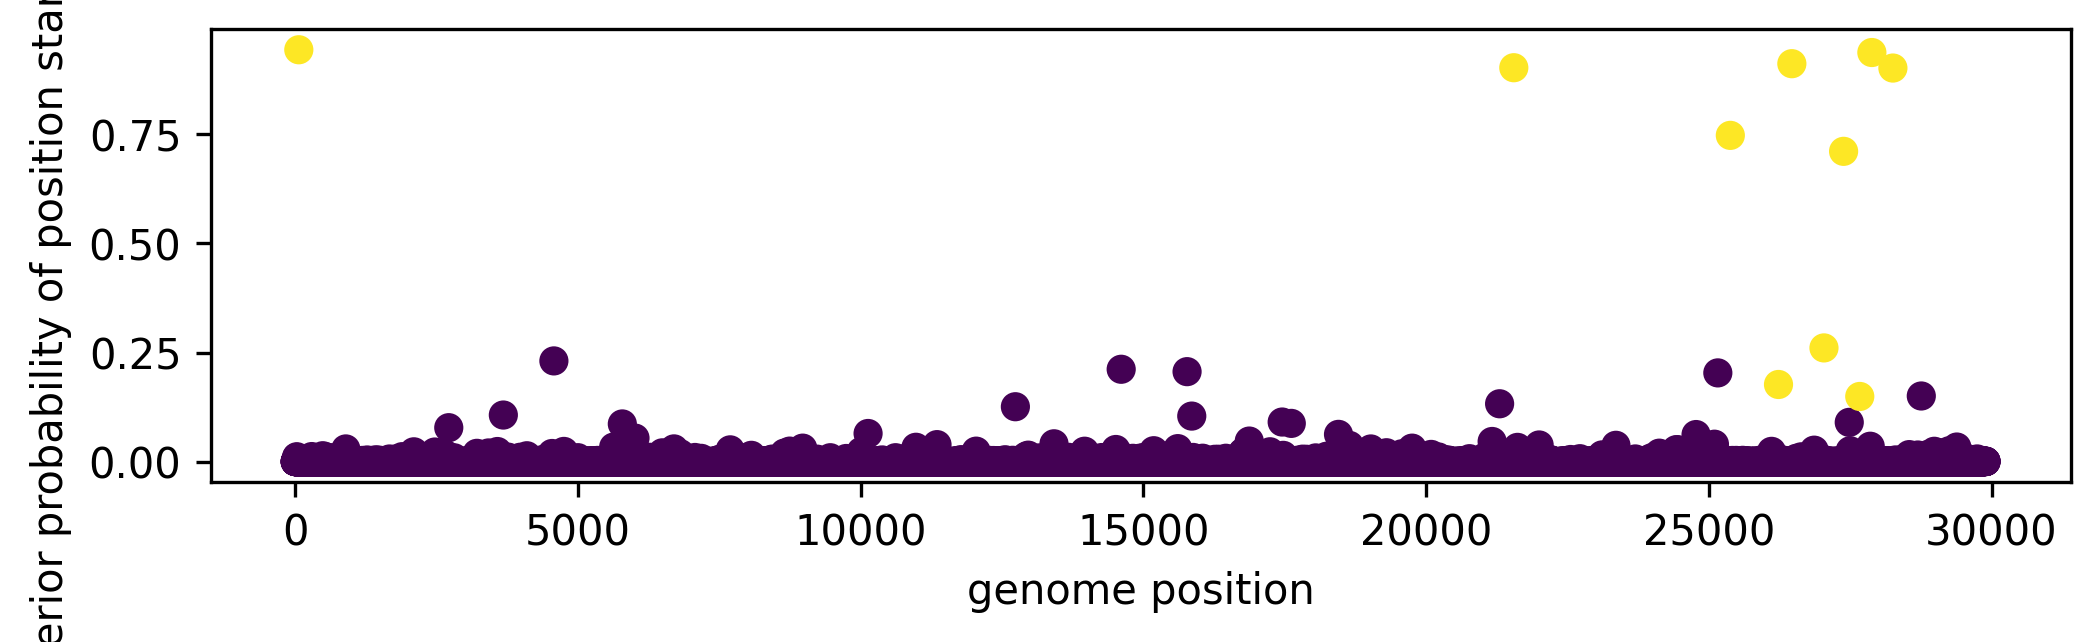

In [14]:
### BEGIN SOLUTION
posterior_matrix = trs_hmm.posterior_matrix(sarscov2_genome)
motif_start_index = trs_hmm.states.index("M1")
probs = posterior_matrix[motif_start_index]
colors = [1 if i in true_trs_positions else 0 for i in range(len(sarscov2_genome))]

plt.figure(figsize=(8, 2), dpi=300)
plt.scatter(range(len(sarscov2_genome)), probs, c=colors)
plt.xlabel("genome position")
plt.ylabel("posterior probability of position starting a TRS")
plt.show()
### END SOLUTION

## PROBLEM 3: Baum–Welch algorithm (25 points)

Suppose we are trying to estimate the parameters of the HMM pictured below, which is the occasionally dishonest casino toy model, but with coin flips instead of die rolls.

![HMM state transition diagram](p3_hmm.png)

We are given two observed sequences, $x^{(1)} =  THTH$ and $x^{(2)} = HTTT$ but not the hidden states corresponding to these sequences. We wish to estimate the parameters of the HMM given these sequences using the Baum–Welch algorithm.  Starting with initial parameters set as depicted above, the forward, backward, and posterior probability matrices for the two sequences are given below.

![HMM DP matrices](p3_hmm_dp_matrices.png)

**By hand**, calculate the following values for the first iteration of the Baum–Welch algorithm.  Do *not* use pseudocounts for any of these values.  *Show your calculations*.

**(a)** $n_{F,H}$, the expectation of the number of times the state F emitted H.

**(b)** $n_{F,T}$, the expectation of the number of times the state F emitted T.

**(c)** $n_{F \rightarrow F}$, the expectation of the number of times there was a transition from F to F

**(d)** $n_{F \rightarrow L}$, the expectation of the number of times there was a transition from F to L

**(e)** The updated estimate for $e_F(H)$

**(f)** The updated estimate for $a_{FF}$

### BEGIN SOLUTION template=Your solution to Problem 3 here

**(a)** 

$n_{F,H} = P(\pi_2 = F | x^{(1)}) + P(\pi_4 = F | x^{(1)}) + P(\pi_1 = F | x^{(2)})
         = 0.677 + 0.708 + 0.512 = 1.897$

**(b)** 

$n_{F,T} = P(\pi_1 = F | x^{(1)}) + P(\pi_3 = F | x^{(1)}) + P(\pi_2 = F | x^{(2)}) + P(\pi_3 = F | x^{(2)}) + P(\pi_4 = F | x^{(2)})
         = 0.595 + 0.663 + 0.398 + 0.343 + 0.334 = 2.333$
         
**(c)** 

$\begin{eqnarray}
n_{F\rightarrow F} & = &
\frac{a_{FF}}{P(x^{(1)})}
    \left(f^1_F(1)e_F(x^{(1)}_2)b^1_F(2) + f^1_F(2)e_F(x^{(1)}_3)b^1_F(3) + f^1_F(3) e_F(x^{(1)}_4) b^1_F(4) \right) +
    \frac{a_{FF}}{P(x^{(2)})}
    \left(f^2_F(1)e_F(x^{(2)}_2)b^2_F(2) + f^2_F(2)e_F(x^{(2)}_3)b^2_F(3) + f^2_F(3) e_F(x^{(2)}_4) b^2_F(4) \right) \\
& = & \frac{a_{FF}}{f^1_F(4) + f^1_L(4)}
    \left(f^1_F(1)e_F(H)b^1_F(2) + 
          f^1_F(2)e_F(T)b^1_F(3) + 
          f^1_F(3) e_F(H) b^1_F(4) \right) +
    \frac{a_{FF}}{f^2_F(4) + f^2_L(4)}
    \left(f^2_F(1)e_F(T)b^2_F(2) + 
          f^2_F(2)e_F(T)b^2_F(3) +
          f^2_F(3) e_F(T) b^2_F(4) \right) \\
& = & \frac{0.9}{0.0319 + 0.0132}
    \left(0.25 \times 0.5 \times 0.23 + 
          0.133 \times 0.5 \times 0.47 +
          0.0635 \times 0.5 \times 1 \right) +
    \frac{0.9}{0.0296 + 0.0591}
    \left(0.25 \times 0.5 \times 0.3 + 
          0.118 \times 0.5 \times 0.53 +
          0.0575 \times 0.5 \times 1 \right) \\
& = & 2.821
\end{eqnarray}$

**(d)** 

$\begin{eqnarray}
n_{F\rightarrow L} & = &
\frac{a_{FL}}{P(x^{(1)})}
    \left(f^1_F(1)e_L(x^{(1)}_2)b^1_L(2) + f^1_F(2)e_L(x^{(1)}_3)b^1_L(3) + f^1_F(3) e_L(x^{(1)}_4) b^1_L(4) \right) +
    \frac{a_{FL}}{P(x^{(2)})}
    \left(f^2_F(1)e_L(x^{(2)}_2)b^2_L(2) + f^2_F(2)e_L(x^{(2)}_3)b^2_L(3) + f^2_F(3) e_L(x^{(2)}_4) b^2_L(4) \right) \\
& = & \frac{a_{FL}}{f^1_F(4) + f^1_L(4)}
    \left(f^1_F(1) e_L(H) b^1_L(2) + 
          f^1_F(2) e_L(T) b^1_L(3) + 
          f^1_F(3) e_L(H) b^1_L(4) \right) +
    \frac{a_{FL}}{f^2_F(4) + f^2_L(4)}
    \left(f^2_F(1) e_L(T) b^2_L(2) + 
          f^2_F(2) e_L(T) b^2_L(3) +
          f^2_F(3) e_L(T) b^2_L(4) \right) \\
& = & \frac{0.1}{0.0319 + 0.0132}
    \left(0.25 \times 0.2 \times 0.189 + 
          0.133 \times 0.8 \times 0.23 +
          0.0635 \times 0.2 \times 1 \right) +
    \frac{0.1}{0.0296 + 0.0591}
    \left(0.25 \times 0.8 \times 0.581 + 
          0.118 \times 0.8 \times 0.77 +
          0.0575 \times 0.8 \times 1 \right) \\
& = & 0.368    
\end{eqnarray}$

**(e)** 

$e_F(H) = \frac{n_{F,H}}{n_{F,H} + n_{F,T}} = \frac{1.897}{1.897 + 2.333} \approx 0.45$

**(f)**

$a_{FF} = \frac{n_{F\rightarrow F}}{n_{F\rightarrow F} + n_{F\rightarrow L}} = \frac{2.821}{2.821 + 0.368} \approx 0.88$


### END SOLUTION

## PROBLEM 4: K-means clustering of sequences (25 points)

So far, we have seen K-means clustering as it is applied to vectors of real numbers.  In this problem, we will consider an extension of this approach to biological sequences.  Assume we are given a set of sequences of equal length.  To apply a K-means-like clustering algorithm to these sequences, we simply need to define (i) the distance between two sequences and (ii) how to compute the "center" (e.g. mean for the case of real-valued vectors) for a cluster of sequences.  In this problem, we will use the following definitions:

(i) The distance between two sequences is the number of positions at which they differ.

(ii) To compute the "center" sequence of a cluster of sequences, we define the character at position $i$ of the center sequence to be the character that occurs most frequently at position $i$ of the sequences in the cluster.  For example, if ACT, CAT, and AAG formed a cluster, their center would be AAT.  If there is a tie for the most frequent character at a position, pick the lexicographically smallest character with that highest frequency.

With these definitions, **run the $k$-means algorithm by hand** on the following set of sequences:

$\begin{eqnarray}
x^1 & = & {\tt TTTAG} \\
x^2 & = & {\tt TATAG} \\
x^3 & = & {\tt CACCG} \\
x^4 & = & {\tt CAACG} \\
x^5 & = & {\tt GATTC} \\
\end{eqnarray}$

Let $k = 2$ and the initial cluster centers be equal to $x^1$ and $x^2$. **For each iteration**, you should show your work for:

**(i)** the assignment of sequences to clusters

**(ii)** the updated cluster centers.


### BEGIN SOLUTION TEMPLATE=Your written solution to 4

![kmeans_solution](kmeans_solution.png)

### END SOLUTION